In [2]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [3]:
%run ../scripts/cardiac_ml_tools.py

In [4]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='../data/intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))

Number of file pairs: 16117
Example of file pair:
../data/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy
../data/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy


In [5]:
X = []
y = []

def normalize_data(data: np.ndarray) -> np.ndarray:
    return (data - np.min(data)) / (np.max(data) - np.min(data))

for pair in file_pairs:
    pECGData = np.load(pair[0])
    pECGData = get_standard_leads(pECGData).T
    pECGData = normalize_data(pECGData)
    VmData = np.load(pair[1]).T
    X.append(pECGData)
    y.append(VmData)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (12893, 12, 500)
X_test shape: (3224, 12, 500)
y_train shape: (12893, 75, 500)
y_test shape: (3224, 75, 500)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, Reshape, LSTM
import numpy as np

def build_model(input_shape: tuple, output_shape: tuple) -> Sequential:
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # CNN layers to extract features from ECG signals
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Flatten the output to fit into Dense layers
        Flatten(),
        
        # Dense layers
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        
        # Output layer
        Dense(np.prod(output_shape), activation='linear'),
        Reshape(output_shape)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Corrected input shape and output shape
input_shape = (12, 500)
output_shape = (75, 500)

model = build_model(input_shape=input_shape, output_shape=output_shape)
model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 64)         │        96,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 37500)          │     4,837,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 500)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,188,540 (19.79 MB)

 Trainable params: 5,188,540 (19.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 1008.4534 - mae: 21.4045 - val_loss: 657.8239 - val_mae: 16.9502
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 637.4996 - mae: 15.9797 - val_loss: 636.7230 - val_mae: 15.6717
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 629.5959 - mae: 15.6827 - val_loss: 633.0725 - val_mae: 15.9205
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 551.5181 - mae: 14.3772 - val_loss: 428.2052 - val_mae: 11.9691
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 422.4262 - mae: 11.9162 - val_loss: 397.6792 - val_mae: 11.8299
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 387.2399 - mae: 11.2171 - val_loss: 356.6986 - val_mae: 10.4594
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 346.1374 - mae: 10.4472 - val_loss: 328.6750 - val_mae: 10.3186
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 328.7666 - mae: 10.1160 - val_loss: 318.7804 - val_mae

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


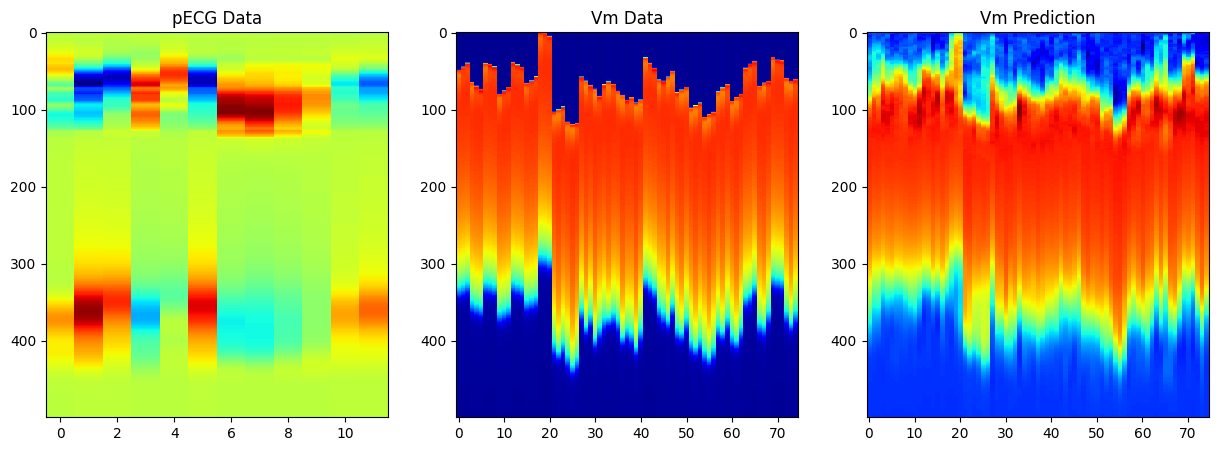

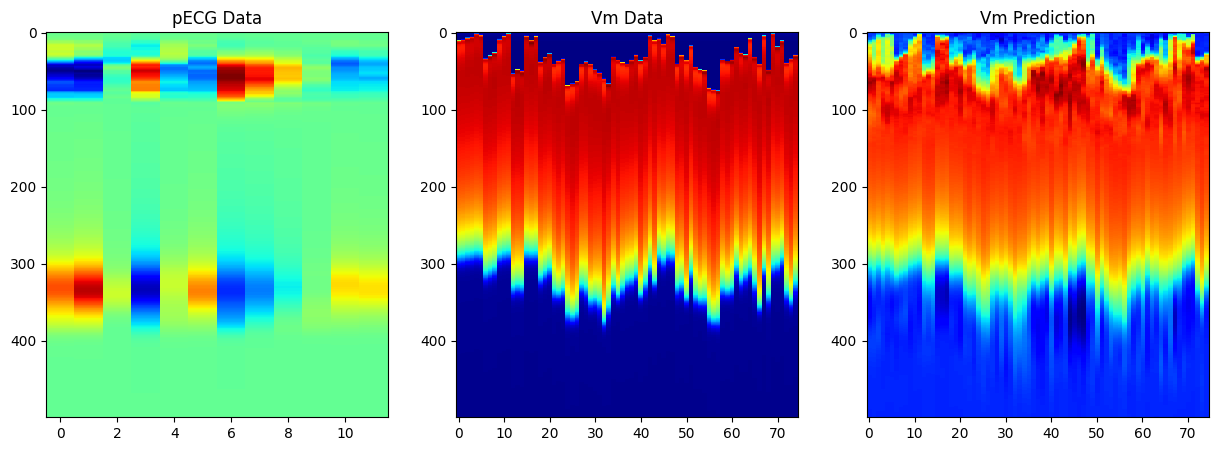

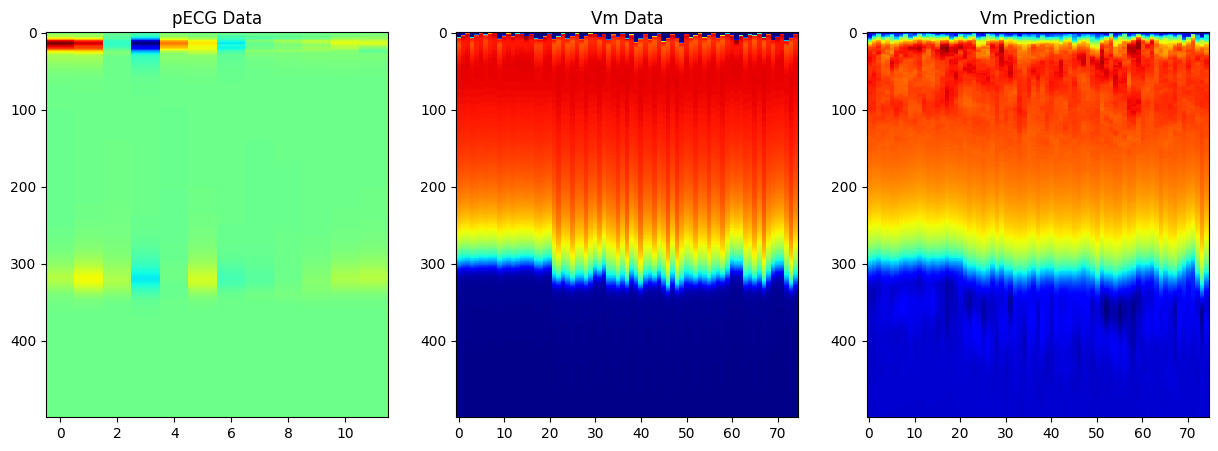

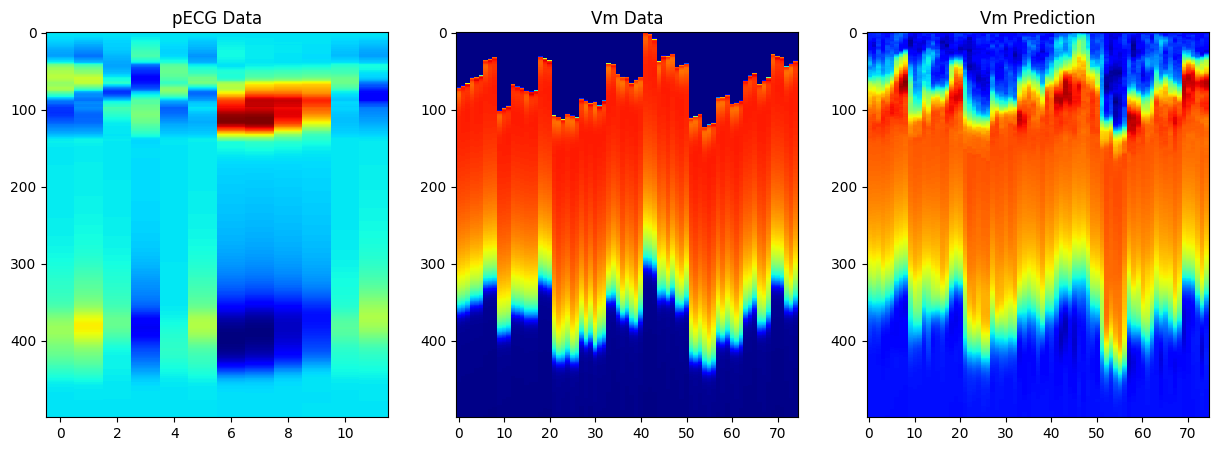

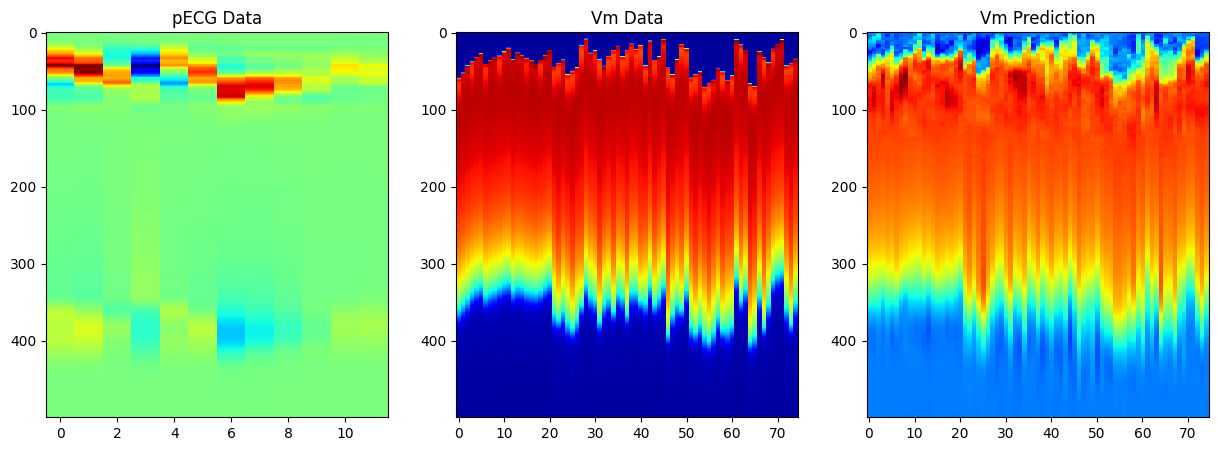

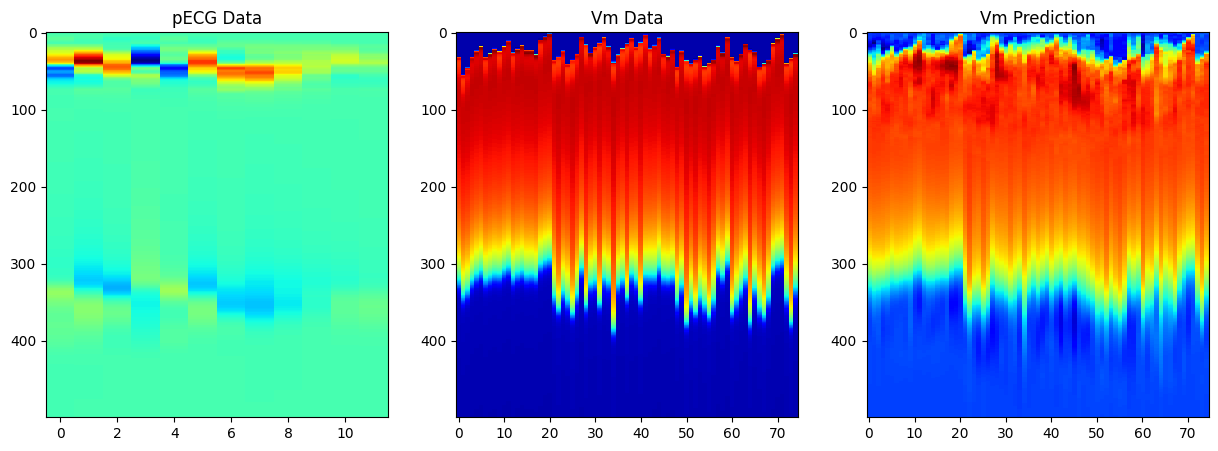

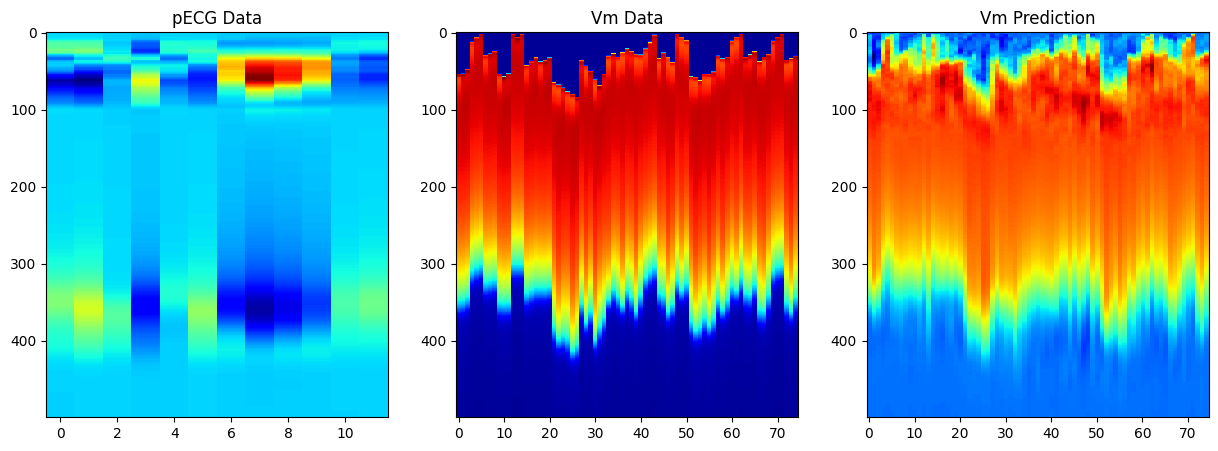

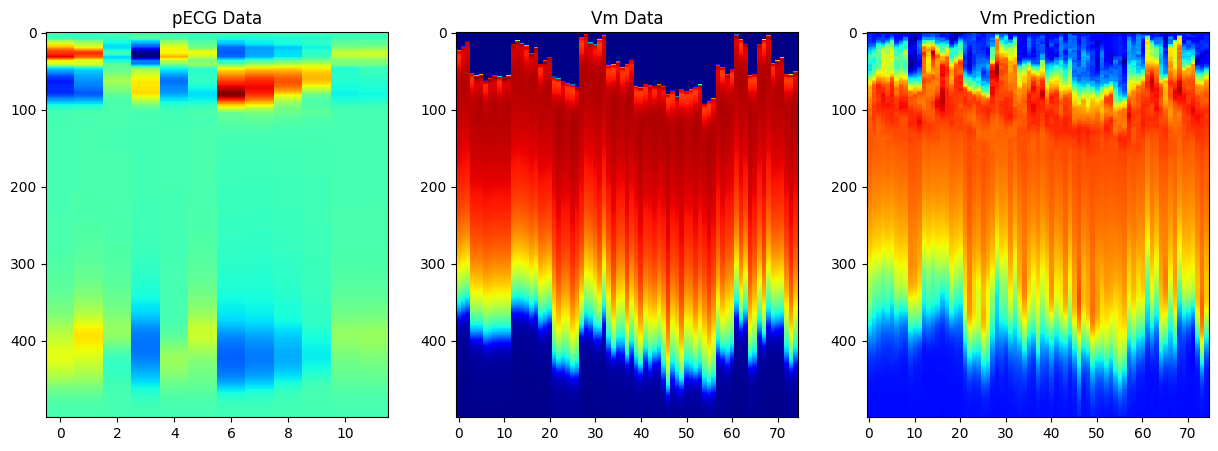

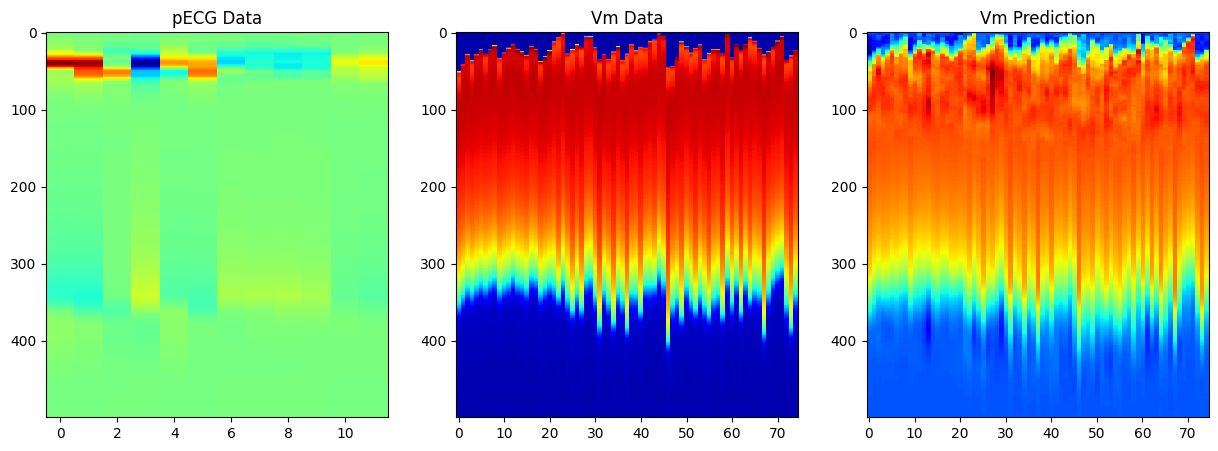

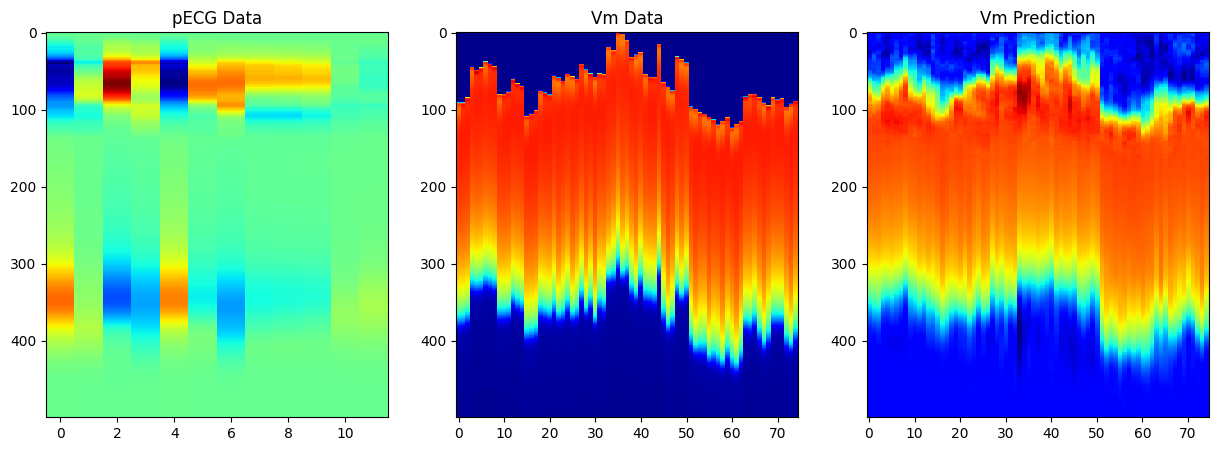

In [9]:
# Predict on test data
y_pred = model.predict(X_test)

# Plot the first 10 samples
for i in range(10):
    pECGData = X_test[i]
    VmData = y_test[i]
    VmPred = y_pred[i]
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
    plt.title('pECG Data')
    
    plt.subplot(1, 3, 2)
    plt.imshow(VmData.T, cmap='jet', interpolation='nearest', aspect='auto')
    plt.title('Vm Data')
    
    plt.subplot(1, 3, 3)
    plt.imshow(VmPred.T, cmap='jet', interpolation='nearest', aspect='auto')
    plt.title('Vm Prediction')
    
    plt.show()
    

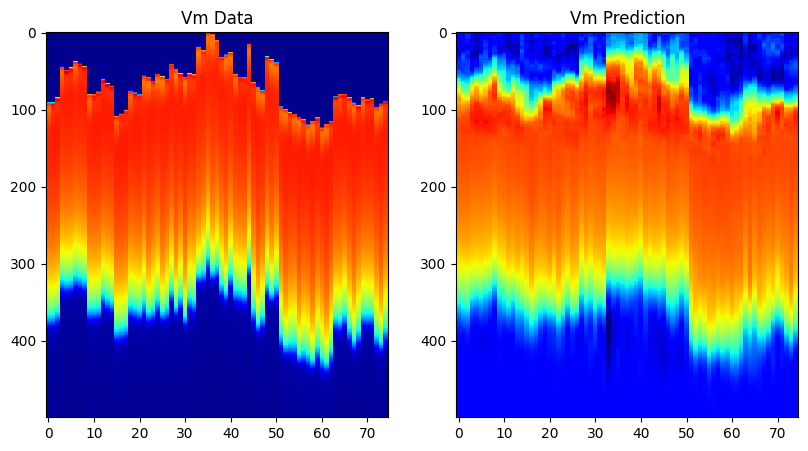

In [10]:
pred = y_test[0]
true = y_pred[0]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 2)
plt.imshow(VmData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Vm Data')

plt.subplot(1, 3, 3)
plt.imshow(VmPred.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Vm Prediction')

plt.show()

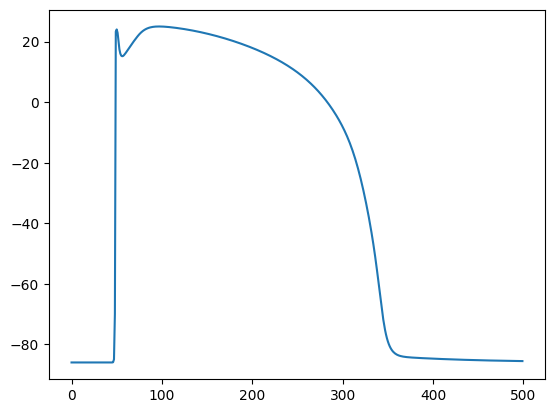

In [41]:
for point in pred:
    plt.plot(point)
    break
    
plt.show()

In [34]:
import pandas as pd

df = pd.DataFrame()
for i in range(500):
    # /var/folders/hz/j_1dsfkn3x50phlp1qy_gfpr0000gn/T/ipykernel_7661/1697301137.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
    df = pd.concat([df, pd.DataFrame(columns=[f'{i+1}'])], axis=1)
    
# Append each pred point to the dataframe
for i, point in enumerate(pred):
    df.loc[i] = point
    
df.head()

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,-85.934901,-85.935641,-85.936152,-85.936493,-85.936732,-85.936912,-85.937057,-85.937181,-85.937290,-85.937391,...,-85.438221,-85.443093,-85.447909,-85.452671,-85.457380,-85.462036,-85.466640,-85.471192,-85.475693,-85.480144
1,-85.964335,-85.964380,-85.964366,-85.964313,-85.964258,-85.964221,-85.964206,-85.964214,-85.964239,-85.964279,...,-85.492384,-85.496928,-85.501421,-85.505864,-85.510257,-85.514601,-85.518897,-85.523145,-85.527347,-85.531501
2,-85.964344,-85.964428,-85.964513,-85.964597,-85.964681,-85.964764,-85.964847,-85.964930,-85.965013,-85.965096,...,-85.511829,-85.516161,-85.520445,-85.524682,-85.528871,-85.533014,-85.537111,-85.541163,-85.545170,-85.549134
3,-85.935888,-85.937080,-85.937661,-85.938000,-85.938227,-85.938396,-85.938532,-85.938650,-85.938755,-85.938853,...,-85.345262,-85.351206,-85.357082,-85.362891,-85.368634,-85.374312,-85.379925,-85.385475,-85.390961,-85.396385
4,-85.964346,-85.964449,-85.964497,-85.964493,-85.964474,-85.964463,-85.964466,-85.964485,-85.964519,-85.964564,...,-85.363750,-85.369768,-85.375717,-85.381598,-85.387412,-85.393160,-85.398842,-85.404460,-85.410013,-85.415504


In [35]:
df.shape

(75, 500)

In [39]:
# normalize the data
df = (df - df.min().min()) / (df.max().max() - df.min().min())
df.head()

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,0.019015,0.019009,0.019006,0.019003,0.019001,0.019000,0.018999,0.018998,0.018997,0.018996,...,0.022767,0.022730,0.022694,0.022658,0.022622,0.022587,0.022552,0.022518,0.022484,0.022450
1,0.018793,0.018792,0.018792,0.018793,0.018793,0.018794,0.018794,0.018794,0.018793,0.018793,...,0.022358,0.022324,0.022290,0.022256,0.022223,0.022190,0.022158,0.022126,0.022094,0.022062
2,0.018793,0.018792,0.018791,0.018791,0.018790,0.018789,0.018789,0.018788,0.018788,0.018787,...,0.022211,0.022178,0.022146,0.022114,0.022082,0.022051,0.022020,0.021989,0.021959,0.021929
3,0.019008,0.018999,0.018994,0.018992,0.018990,0.018989,0.018988,0.018987,0.018986,0.018985,...,0.023469,0.023424,0.023380,0.023336,0.023293,0.023250,0.023208,0.023166,0.023124,0.023083
4,0.018793,0.018792,0.018791,0.018792,0.018792,0.018792,0.018792,0.018792,0.018791,0.018791,...,0.023330,0.023284,0.023239,0.023195,0.023151,0.023108,0.023065,0.023022,0.022980,0.022939


In [40]:
df.to_csv('pred.csv', index=False)